<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />
  
# Capacidades de Analítica Avanzada en la Base de Datos 
# (In-Database)

## Caso 1: Modelos de Regresión Logística y Gradient Boosting
    
![Slide](images/Diapositiva4.PNG)

![Slide](images/Diapositiva8.PNG)

![Slide](images/Diapositiva5.PNG)

![Slide](images/Diapositiva6.PNG)


## **Instalar las librerías**

In [ ]:
#!pip install teradataml==17.20.0.4 kds==0.1.3 lightgbm==4.0.0 nyoka==4.3.0 sklearn2pmml==0.95.1 xgboost==1.7.3

## **Carga de Modulos**

In [1]:
import pandas as pd
import numpy as np
import getpass as gp
import plotly.express as px
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import kds

from teradataml import *
from teradataml.analytics.valib import *
configure.val_install_location = "val"

C:\TDAPPS\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
con=create_context(host = "20.172.147.24", username="pocuser", password = gp.getpass())

 ········


![Slide](images/Diapositiva10.PNG)

## **Lectura Inicial de base de datos**

In [7]:
# Leemos la data de desarrollo de modelos
tdf = DataFrame(in_schema("DW_LANDING","caso1_des"))

In [8]:
# Primeros Registros
tdf.head(10)

LAB_0002,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021
101300,2,0,2,0,0,9147,7634,67,52,5,1710,20.090513229370117,0.46311259269714355,939851.9375,8696466.0,0.9413179755210876,1616.37353515625,6,140598.109375,946207.375,7141492.0
103107,1,0,0,0,0,6476,429,100,42,2,289,9.323673248291016,0.18798847496509552,539996.4375,6087684.5,0.06356780230998993,252.7029266357422,2,59794.734375,4153.18212890625,4270622.5
103155,1,0,2,1,0,2300,3960,68,40,1,4722,7.613104343414307,0.76704341173172,602939.625,2661623.0,0.8268604278564453,1663.0889892578125,10,91704.5234375,904872.0,6109602.0
105860,1,2,1,0,0,1242,3583,19,43,2,4305,11.318902015686035,0.5312799215316772,2585184.25,6027301.5,0.6342238187789917,498.5674133300781,9,26141.5,210400.734375,424617.90625
106450,0,0,1,0,0,2327,67,62,52,7,230,31.31117820739746,0.6833862662315369,1057613.625,2780020.75,1.0032362937927246,23.57093048095703,4,7154.9853515625,460610.0,2142339.75
107166,0,2,1,0,0,10011,2704,0,18,4,287,29.16120719909668,0.1718500256538391,661941.0625,783167.3125,0.582207441329956,1162.7119140625,6,49871.70703125,3553549.5,1754564.5
106083,0,2,1,0,0,10007,759,9,13,1,602,8.189626693725586,0.9464216232299805,851691.25,5645864.0,1.0272371768951416,1244.2496337890625,2,214485.609375,2373358.0,9769053.0
102495,2,0,0,1,0,8265,746,12,15,2,2892,15.026856422424316,0.654789388179779,1911655.875,1098042.625,0.9636686444282532,105.93802642822266,9,96737.125,1000252.1875,2272706.75
100802,0,0,0,0,0,7712,4028,19,12,3,1381,26.632911682128906,0.9733006954193115,1015282.125,3384812.0,0.3273318409919739,1660.5762939453125,11,103357.375,2021752.375,3550215.75
100117,2,0,0,0,0,5186,9750,31,9,6,4670,17.276762008666992,0.9409305453300476,1925679.125,3578627.75,0.8557526469230652,406.2515563964844,0,205505.484375,2451969.5,895126.3125


In [9]:
# Demostrando que no es head() de Python, sino es una funcion de la librería TeradataML con el mismo nombre
tdf.head(5).show_query()

'select "LAB_0002","VAR_0001","VAR_0002","VAR_0003","VAR_0004","VAR_0005","VAR_0006","VAR_0007","VAR_0008","VAR_0009","VAR_0010","VAR_0011","VAR_0012","VAR_0013","VAR_0014","VAR_0015","VAR_0016","VAR_0017","VAR_0018","VAR_0019","VAR_0020","VAR_0021" from (select * from (select row_number() over (order by "LAB_0002" asc) - 1 as tdml_row_num, "LAB_0002","VAR_0001","VAR_0002","VAR_0003","VAR_0004","VAR_0005","VAR_0006","VAR_0007","VAR_0008","VAR_0009","VAR_0010","VAR_0011","VAR_0012","VAR_0013","VAR_0014","VAR_0015","VAR_0016","VAR_0017","VAR_0018","VAR_0019","VAR_0020","VAR_0021" from "DW_LANDING"."caso1_des") as temp_table where tdml_row_num < 5) as temp_table'

In [10]:
tdf.dtypes

COLUMN NAME,TYPE
LAB_0002,str
VAR_0001,str
VAR_0002,str
VAR_0003,str
VAR_0004,int
VAR_0005,int
VAR_0006,int
VAR_0007,int
VAR_0008,int
VAR_0009,int


In [11]:
# Vemos la dimensionalidad
tdf.shape

(1035, 22)

![Slide](images/Diapositiva6.PNG)

## **Exploración de los datos**

In [12]:
# Estadísticas Descriptivas por Columna
valS = valib.Statistics(data=tdf, columns="allnumeric")
valS.result.head(21).sort('xcol')

xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd
DW_LANDING,caso1_des,VAR_0004,1035.0,0.0,1.0,0.26666666666666666,0.4422166387140533
DW_LANDING,caso1_des,VAR_0005,1035.0,0.0,0.0,0.0,0.0
DW_LANDING,caso1_des,VAR_0006,1035.0,38.0,10056.0,5196.434782608696,2886.7976926363335
DW_LANDING,caso1_des,VAR_0007,1035.0,5.0,9971.0,4988.408695652174,2832.610574843753
DW_LANDING,caso1_des,VAR_0008,1035.0,0.0,101.0,50.30338164251208,29.98474230626619
DW_LANDING,caso1_des,VAR_0009,1035.0,0.0,58.0,28.565217391304348,16.56025005721749
DW_LANDING,caso1_des,VAR_0010,1035.0,0.0,7.0,3.4956521739130433,2.29654864650856
DW_LANDING,caso1_des,VAR_0011,1035.0,2.0,4986.0,2524.295652173913,1433.4899521882162
DW_LANDING,caso1_des,VAR_0012,1035.0,1.0734882354736328,36.9784049987793,18.746701281773294,10.316671118763942
DW_LANDING,caso1_des,VAR_0013,1035.0,0.00010000199836213142,0.9787647128105164,0.4889879028581264,0.2854152936805041


In [13]:
# Agregando show_query() al final, podemos ver que efectivamente, los códigos se traducen automáticamente a lenguaje SQL antes de ejecutarse
valS.result.show_query()

'select * from "POCUSER"."ml__valib_statistics_1697234769286506"'

### Análisis Univariado

In [ ]:
## Para variables Cualitativas
def plot_cat(feature):
    catfreq = valib.Frequency(data=tdf, columns=feature)
    df=catfreq.result.to_pandas().reset_index()
    fig = px.bar(df, x='xval', y='xcnt')
    fig.update_xaxes(tickangle = 0, title=feature)
    fig.update_yaxes(title="Frecuencia")  
    fig.show()

In [ ]:
## Graficando otras variables categóricas
plot_cat('VAR_0001')

In [ ]:
## Distribución de la Variable Target
plot_cat('VAR_0004')

In [ ]:
## Calculando la proporción del Target
tResp = valib.Frequency(data=tdf, columns="VAR_0004")
tResp.result

In [ ]:
## Para variables cuantitativas
def plot_num(feature):
    df=tdf.filter(items=['LAB_0002', feature]).to_pandas()
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(18,6)

In [ ]:
## Analizando la distribución de algunas variables numéricas
plot_num('VAR_0006')

In [ ]:
plot_num('VAR_0012')

### Transformación de Datos

In [14]:
## Aplicando One Hot Encoding
fit_one = OneHotEncodingFit(data=tdf,
                            is_input_dense=True,
                            target_column='VAR_0002',
                            categorical_values=['0','1','2'],
                            other_column="other")

In [15]:
fit_one.result

VAR_0002,VAR_0002_0,VAR_0002_1,VAR_0002_2,VAR_0002_other
None,0,1,2,None


In [16]:
## Aplicando la transformación
one = OneHotEncodingTransform(data=tdf,
                              object=fit_one.result,
                              is_input_dense=True)

In [17]:
one.result.head()

LAB_0002,VAR_0001,VAR_0002_0,VAR_0002_1,VAR_0002_2,VAR_0002_other,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021
101300,2,1,0,0,0,2,0,0,9147,7634,67,52,5,1710,20.090513229370117,0.46311259269714355,939851.9375,8696466.0,0.9413179755210876,1616.37353515625,6,140598.109375,946207.375,7141492.0
103107,1,1,0,0,0,0,0,0,6476,429,100,42,2,289,9.323673248291016,0.18798847496509552,539996.4375,6087684.5,0.06356780230998993,252.7029266357422,2,59794.734375,4153.18212890625,4270622.5
103155,1,1,0,0,0,2,1,0,2300,3960,68,40,1,4722,7.613104343414307,0.76704341173172,602939.625,2661623.0,0.8268604278564453,1663.0889892578125,10,91704.5234375,904872.0,6109602.0
105860,1,0,0,1,0,1,0,0,1242,3583,19,43,2,4305,11.318902015686035,0.5312799215316772,2585184.25,6027301.5,0.6342238187789917,498.5674133300781,9,26141.5,210400.734375,424617.90625
106450,0,1,0,0,0,1,0,0,2327,67,62,52,7,230,31.31117820739746,0.6833862662315369,1057613.625,2780020.75,1.0032362937927246,23.57093048095703,4,7154.9853515625,460610.0,2142339.75
107166,0,0,0,1,0,1,0,0,10011,2704,0,18,4,287,29.16120719909668,0.1718500256538391,661941.0625,783167.3125,0.582207441329956,1162.7119140625,6,49871.70703125,3553549.5,1754564.5
106083,0,0,0,1,0,1,0,0,10007,759,9,13,1,602,8.189626693725586,0.9464216232299805,851691.25,5645864.0,1.0272371768951416,1244.2496337890625,2,214485.609375,2373358.0,9769053.0
102495,2,1,0,0,0,0,1,0,8265,746,12,15,2,2892,15.026856422424316,0.654789388179779,1911655.875,1098042.625,0.9636686444282532,105.93802642822266,9,96737.125,1000252.1875,2272706.75
100802,0,1,0,0,0,0,0,0,7712,4028,19,12,3,1381,26.632911682128906,0.9733006954193115,1015282.125,3384812.0,0.3273318409919739,1660.5762939453125,11,103357.375,2021752.375,3550215.75
100117,2,1,0,0,0,0,0,0,5186,9750,31,9,6,4670,17.276762008666992,0.9409305453300476,1925679.125,3578627.75,0.8557526469230652,406.2515563964844,0,205505.484375,2451969.5,895126.3125


In [18]:
## Aplicando ScaleFit
fit_scal = ScaleFit(data=tdf,
                   target_columns=['VAR_0006','VAR_0007','VAR_0008','VAR_0011','VAR_0012','VAR_0013','VAR_0015','VAR_0016','VAR_0018','VAR_0019','VAR_0020'],
                   scale_method="RANGE",
                   miss_value="KEEP",
                   global_scale=False)
fit_scal.output

TD_STATTYPE_SCLFIT,VAR_0006,VAR_0007,VAR_0008,VAR_0011,VAR_0012,VAR_0013,VAR_0015,VAR_0016,VAR_0018,VAR_0019,VAR_0020
location,38.0,5.0,0.0,2.0,1.0734882354736328,0.00010000199836213142,11216.34375,1.5700000000000002e-05,0.0,121.55374145507812,839.6156005859375
globalscale_false,None,None,None,None,None,None,None,None,None,None,None
sum,5378310.0,5163003.0,52064.0,2612646.0,19402.83582663536,506.1024794581608,4635641381.1875,540.577840325012,5783.0,118129607.70892334,1805160461.4707031
null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
multiplier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,10056.0,9971.0,101.0,4986.0,36.9784049987793,0.9787647128105164,9093673.0,1.0297356843948364,11.0,224465.265625,3568696.5
min,38.0,5.0,0.0,2.0,1.0734882354736328,0.00010000199836213142,11216.34375,1.5700000000000002e-05,0.0,121.55374145507812,839.6156005859375
count,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0,1035.0
scale,10018.0,9966.0,101.0,4984.0,35.904916763305664,0.9786647108121542,9082456.65625,1.0297199843948364,11.0,224343.71188354492,3567856.884399414
missvalue_KEEP,None,None,None,None,None,None,None,None,None,None,None


In [19]:
## Aplicando la transformación
scal = ScaleTransform(data=one.result, 
                     object=fit_scal.output,
                     accumulate=['LAB_0002','VAR_0002_1','VAR_0002_2','VAR_0004'])

In [20]:
scal.result.head()

LAB_0002,VAR_0002_1,VAR_0002_2,VAR_0004,VAR_0006,VAR_0007,VAR_0008,VAR_0011,VAR_0012,VAR_0013,VAR_0015,VAR_0016,VAR_0018,VAR_0019,VAR_0020
101300,0,0,0,0.9092633260131763,0.7655027092113185,0.6633663366336634,0.34269662921348315,0.5296496053524242,0.4731064537052184,0.9562665680626545,0.9141342207457385,0.5454545454545454,0.6261666727992145,0.26496795976684756
103107,0,0,0,0.6426432421641046,0.042544651816175,0.9900990099009901,0.05758426966292135,0.22977869764201653,0.19198451818172982,0.6690335430413027,0.06171784880657564,0.18181818181818182,0.2659899853334013,0.0009287274225625485
103155,0,0,1,0.22579357157117189,0.3968492875777644,0.6732673267326733,0.9470304975922953,0.18213706359637274,0.7836630883491268,0.2918160533610859,0.80298016974234,0.9090909090909091,0.4082261496305496,0.2533824684370971
105860,0,1,0,0.12018366939508884,0.3590206702789484,0.18811881188118812,0.8633627608346709,0.28534848995063194,0.5427598580646792,0.6623852316553686,0.6159034770522728,0.8181818181818182,0.11598250755542315,0.058735853360802615
106450,0,0,0,0.2284887203034538,0.006221151916516155,0.6138613861386139,0.045746388443017656,0.8421601467915485,0.6981821830135707,0.3048519261960557,0.9742654401160472,0.36363636363636365,0.03135114218738799,0.12886458153906818
107166,0,1,0,0.9955080854461968,0.27082079068834036,0.0,0.05718298555377207,0.7822805759106595,0.1754942441042434,0.08499363090478278,0.5653884067056429,0.5454545454545454,0.22175862595881377,0.9957545942870548
106083,0,1,0,0.9951088041525255,0.07565723459763195,0.0891089108910891,0.12038523274478331,0.198193982878817,0.9669518178971676,0.6203880590360511,0.9975736049240967,0.18181818181818182,0.9555162203290085,0.6649701659204265
102495,0,0,1,0.8212218007586345,0.07435279951836243,0.1188118811881188,0.5798555377207063,0.388619984247139,0.668961881376224,0.11966214895197012,0.9358398001711014,0.8181818181818182,0.4306586997575279,0.28011565605935107
100802,0,0,0,0.7660211619085646,0.4036724864539434,0.18811881188118812,0.27668539325842695,0.7118641609768792,0.9944168648048314,0.37144087595821274,0.3178690769843966,1.0,0.4601681071949716,0.5664220356584172
100117,0,0,0,0.5138750249550809,0.9778246036524182,0.3069306930693069,0.9365971107544141,0.45128286691233566,0.9613410322631623,0.39278044930664463,0.8310384957964854,0.0,0.9154877973141414,0.6870034207697819


### Matriz de correlaciones

In [ ]:
## Función de VAL para el cálculo In-Database de la matriz de correlaciones
Cor_Mat = valib.Matrix(data=scal.result, columns="allnumeric", exclude_columns=["LAB_0002"], type="COR")
## Imprimir los resultados
Cor_Mat.result.sort('rownum').head(21)

In [ ]:
## Graficando la Matriz de Correlaciones - Más claro significa correlación más alta
sns.set(rc = {'figure.figsize':(16,12)})
sns.heatmap(Cor_Mat.result.to_pandas().sort_values(['rownum']))

Observamos que existen correlaciones significativas entre los grupos de variables históricas

![Slide](images/Diapositiva9.PNG)

## **Modelo de Regresión Logística In-Database**

### Particion Muestral

Seleccionamos las variables más relevantes y dividimos en muestras 70% Train / 30% Test

In [21]:
## Seleccionamos variables más relevantes y generamos una columna que divide la tabla en muestras de entrenamiento y test
tbl_sample = scal.result[['LAB_0002','VAR_0002_1','VAR_0002_2','VAR_0004','VAR_0006','VAR_0007','VAR_0008',
                         'VAR_0011','VAR_0012','VAR_0013','VAR_0015','VAR_0016','VAR_0018','VAR_0019','VAR_0020']].sample(frac = [0.7, 0.3])

In [22]:
## Almacenando la Muestra de Entrenamiento en la BD y generando la referencia con un DF de TeradataML
copy_to_sql(tbl_sample[tbl_sample.sampleid == "1"].drop("sampleid", axis = 1), schema_name="DW_LANDING", table_name="TrainModel", if_exists="replace")
tbl_train = DataFrame(in_schema("DW_LANDING","TrainModel"))
tbl_train.shape

(725, 15)

In [23]:
## Almacenando la Muestra de Test en la BD y generando la referencia con un DF de TeradataML
copy_to_sql(tbl_sample[tbl_sample.sampleid == "2"].drop("sampleid", axis = 1), schema_name="DW_LANDING", table_name="TestModel", if_exists="replace")
tbl_test = DataFrame(in_schema("DW_LANDING","TestModel"))
tbl_test.shape

(310, 15)

In [24]:
## Verificando que el DF hace referencia a la tabla creada en la BD
tbl_test.show_query()

'select * from "DW_LANDING"."TestModel"'

<font color='red'/>

### Entrenamiento del Modelo In-Database utilizando VAL

In [25]:
## Función de VAL que entrena un Modelo de Regresión Logística
tdModel = valib.LogReg(data=tbl_train,
                       columns="all",
                       exclude_columns=["LAB_0002"],
                       stepwise='True',
                       response_column="VAR_0004")
tdModel.model.to_pandas().sort_values(['Column Name'])

,B Coefficient,Standard Error,Wald Statistic,T Statistic,P-Value,Odds Ratio,Lower,Upper,Partial R,Standardized Coefficient
Column Name,,,,,,,,,,
(Constant),-4.216689,0.655994,41.318409,-6.427940,2.355521e-10,NaN,NaN,NaN,NaN,NaN
VAR_0002_1,0.760556,0.323750,5.518772,2.349207,1.908314e-02,2.139466,1.134302,4.035359,0.064484,0.200185
VAR_0006,7.318645,0.817032,80.238503,8.957595,0.000000e+00,1508.159690,304.080139,7480.086193,0.304066,1.166254
VAR_0011,10.686044,1.027206,108.222718,10.403015,0.000000e+00,43741.124681,5841.578643,327528.927589,0.354296,1.682443
VAR_0015,-7.530070,0.825714,83.164632,-9.119464,7.444420e-19,0.000537,0.000106,0.002708,-0.309700,-1.201301
VAR_0019,-10.422672,1.067671,95.297873,-9.762063,3.178941e-21,0.000030,0.000004,0.000241,-0.332042,-1.641443


In [26]:
## Métricas estadísticas del Modelo
tdModel.statistical_measures.to_pandas()

,Total Observations,Total Iterations,Initial Log Likelihood,Final Log Likelihood,Likelihood Ratio Test G Statistic,Chi-Square Degrees of Freedom,Chi-Square Value,Chi-Square Probability,McFaddens Pseudo R-Squared,Dependent Variable,Dependent Response Value,Total Distinct Values
rid,,,,,,,,,,,,
1,725.0,8.0,-423.111096,-137.038604,572.144984,5.0,11.070498,0.0,0.676117,VAR_0004,1.0,2.0


### Validación del Modelo

In [27]:
## Usando la muestra de Test se pueden generar los estadísticos de validación
obj = valib.LogRegEvaluator(data=tbl_test, model=tdModel.model, index_columns='LAB_0002')

In [28]:
from IPython.core.display import display, HTML
cursor=con.raw_connection().cursor()
parms = 'database=' + obj.result._table_name.split('.')[0] + ';tablename=' + obj.result._table_name.split('.')[1] + ';analysistype=logistic'
cursor.callproc("val.td_analyze", ['report',parms])
cursor.nextset()
z=cursor.fetchall()
# Loop in case of group by generating multiple reports
for i in range(len(z)):
    display(HTML(z[i][1]))

C:\Users\lc250058\AppData\Local\Temp\ipykernel_67536\4018311291.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<font color='red'/>

### Scoring del Modelo In-Database utilizando VAL

In [29]:
# Leemos la data de desarrollo de modelos
tdfs = DataFrame(in_schema("DW_LANDING","caso1_score"))

In [30]:
tdfs.shape

(4000000, 22)

In [31]:
onesc = OneHotEncodingTransform(data=tdfs,
                              object=fit_one.result,
                              is_input_dense=True)

In [32]:
## Aplicando la transformación
inputScore = ScaleTransform(data=onesc.result, 
                     object=fit_scal.output,
                     accumulate=['LAB_0002','VAR_0002_1','VAR_0002_2','VAR_0004'])

In [33]:
## Función de Scoring de la Regresión Logística en VAL
Logit_Model_Score = valib.LogRegPredict(data=inputScore.result, 
                                        model=tdModel.model, 
                                        index_columns="LAB_0002",
                                        estimate_column="PRED_VAR_0004",
                                        prob_column="PROB")
 
## Mostramos los primeros 10 registros de la tabla 
Logit_Model_Score.result.head(10)

LAB_0002,PROB,PRED_VAR_0004
ID_11,0.017987943858605138,0.0
ID_11000,0.00029079433124939346,0.0
ID_110000,0.16067159428660463,0.0
ID_110000,0.1450626880382172,0.0
ID_1100000,5.837709282054311e-05,0.0
ID_1100000,0.11834897972121415,0.0
ID_110000,0.10870990952308067,0.0
ID_1100,0.0036338445965058866,0.0
ID_11,0.9990416622629644,1.0
ID_10,0.08449155592932561,0.0


In [34]:
## Tabla temporal donde se almacenan los resultados del modelo
tdModel.model.show_query()

'select * from "POCUSER"."ml__valib_logreg_1697229547608126"'

In [35]:
## Almacenando el resultado en una Tabla permanente de la BD
copy_to_sql(tdModel.model, schema_name="DW_LANDING", table_name="ScoreLogRes", if_exists="replace")

![Slide](images/Diapositiva11.PNG)

![Slide](images/Diapositiva12.PNG)


## **Entrenamiento de un modelo Gradient Boosting 100% Python**


In [37]:
## Movemos los datos a Python con to_pandas()
pdf = scal.result[['VAR_0002_1','VAR_0002_2','VAR_0004','VAR_0006','VAR_0007','VAR_0008','VAR_0011',
                  'VAR_0012','VAR_0013','VAR_0015','VAR_0016','VAR_0018','VAR_0019','VAR_0020']].to_pandas(all_rows=True)
pdf.head(5)

,VAR_0002_1,VAR_0002_2,VAR_0004,VAR_0006,VAR_0007,VAR_0008,VAR_0011,VAR_0012,VAR_0013,VAR_0015,VAR_0016,VAR_0018,VAR_0019,VAR_0020
0,0,1,0,0.575963,0.040036,0.188119,0.825642,0.138059,0.069044,0.644258,0.690399,0.363636,0.738674,0.840197
1,0,0,0,0.074067,0.791090,0.861386,0.046148,0.124101,0.496663,0.456663,0.969448,0.181818,0.368196,0.450395
2,1,0,1,0.944700,0.413105,0.564356,0.593098,0.103689,0.552722,0.745782,0.531855,0.454545,0.579055,0.168954
3,0,1,0,0.734977,0.088802,0.792079,0.326645,0.964489,0.848109,0.295132,0.813165,0.545455,0.819426,0.760378
4,0,0,0,0.506688,0.347381,0.821782,0.246790,0.988392,0.497164,0.753946,0.972727,0.090909,0.245405,0.707228


In [38]:
pdf.shape

(1035, 14)

In [39]:
X = pdf.drop(["VAR_0004"],axis=1)
y = pdf.VAR_0004

In [40]:
## Creando las muestras de Entrenamiento y Test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=12345) 

### Entrenando el Modelo y Exportando como PMML

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

In [ ]:
gb_params = {'max_depth': [3,4,5],
             'learning_rate': [0.22,0.19,0.15],
             'n_estimators': [65,75,85]}

In [ ]:
gbm=GradientBoostingClassifier()
optimized_GBM = GridSearchCV(gbm, gb_params, scoring = 'f1', cv = 5, verbose=-1)
opGBM=optimized_GBM.fit(X_train, y_train)
print (opGBM.best_params_)

In [ ]:
## Se crea el Pipeline para Exportar el modelo en formato PMML
pipeline = PMMLPipeline([("classifier", GradientBoostingClassifier(n_estimators=75, max_depth=3, learning_rate=0.19))])
pipeline.fit(X_train, y_train)
sklearn2pmml(pipeline, "ModelGBMPy.pmml", with_repr = True)

In [ ]:
# Métricas de Evaluación
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:, 1]
print('Area bajo la Curva ROC: ',roc_auc_score(y_test, y_probs))
print('Matriz de Confusión: ',confusion_matrix(y_test,y_pred))
print('Métricas de Clasificación: ', classification_report(y_test,y_pred))

In [ ]:
# Reporte de Deciles y Gráficos
kds.metrics.report(y_test, y_probs, plot_style='ggplot')

## **Entrenamiento de un modelo XGBoost 100% Python**

In [ ]:
from xgboost import XGBClassifier

In [41]:
## Se crea el Pipeline para Exportar el modelo en formato PMML
pipeline = PMMLPipeline([("classifier", XGBClassifier(eval_metric='aucpr', use_label_encoder=False, n_estimators=150, max_depth=5))])
pipeline.fit(X_train, y_train)
sklearn2pmml(pipeline, "ModelXGBPy.pmml", with_repr = True)

C:\TDAPPS\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [42]:
# Métricas de Evaluación
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:, 1]
print('Area bajo la Curva ROC: ',roc_auc_score(y_test, y_probs))
print('Matriz de Confusión: ',confusion_matrix(y_test,y_pred))
print('Métricas de Clasificación: ', classification_report(y_test,y_pred))

Area bajo la Curva ROC:  0.9609154929577465
Matriz de Confusión:  [[230  10]
 [ 21  50]]
Métricas de Clasificación:                precision    recall  f1-score   support

           0       0.92      0.96      0.94       240
           1       0.83      0.70      0.76        71

    accuracy                           0.90       311
   macro avg       0.87      0.83      0.85       311
weighted avg       0.90      0.90      0.90       311



LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.971,1.000,0.996,32.0,32.0,0.0,7.1,32,100.000,32.0,32.0,32,0.0,10.289,45.070,45.070,0.000,45.070,4.380
1,2,0.457,0.969,0.771,31.0,19.0,12.0,7.1,31,61.290,63.0,51.0,63,12.0,20.257,71.831,88.732,5.000,66.831,3.546
2,3,0.062,0.426,0.215,31.0,14.0,17.0,7.1,8,45.161,94.0,65.0,71,29.0,30.225,91.549,100.000,12.083,79.466,3.029
3,4,0.005,0.057,0.019,31.0,4.0,27.0,7.1,0,12.903,125.0,69.0,71,56.0,40.193,97.183,100.000,23.333,73.850,2.418
4,5,0.002,0.005,0.003,31.0,2.0,29.0,7.1,0,6.452,156.0,71.0,71,85.0,50.161,100.000,100.000,35.417,64.583,1.994
5,6,0.000,0.001,0.001,31.0,0.0,31.0,7.1,0,0.000,187.0,71.0,71,116.0,60.129,100.000,100.000,48.333,51.667,1.663
6,7,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,218.0,71.0,71,147.0,70.096,100.000,100.000,61.250,38.750,1.427
7,8,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,249.0,71.0,71,178.0,80.064,100.000,100.000,74.167,25.833,1.249
8,9,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,280.0,71.0,71,209.0,90.032,100.000,100.000,87.083,12.917,1.111
9,10,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,311.0,71.0,71,240.0,100.000,100.000,100.000,100.000,0.000,1.000


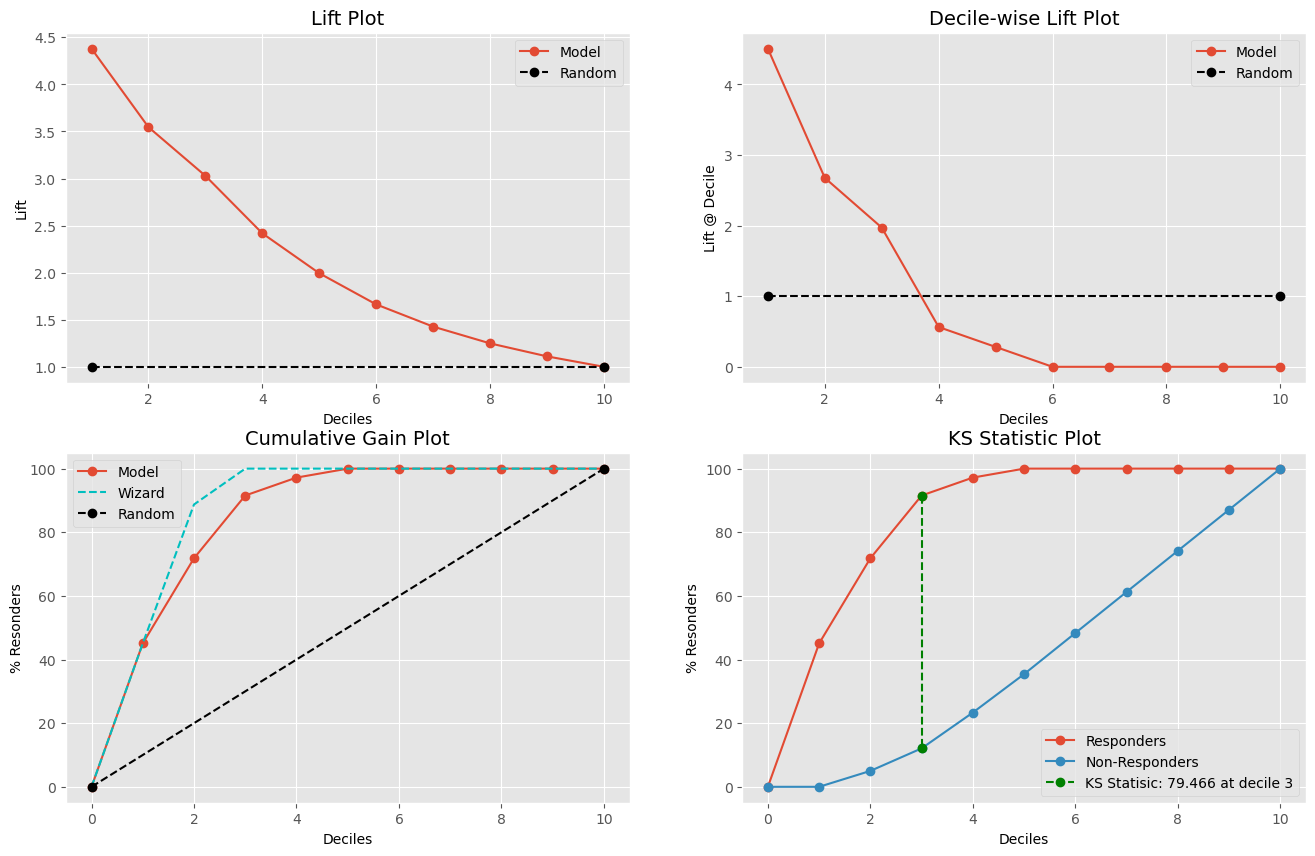

In [43]:
# Reporte de Deciles y Gráficos
kds.metrics.report(y_test, y_probs, plot_style='ggplot')

## **Entrenamiento de un modelo LightGBM 100% Python**

In [44]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from nyoka import lgb_to_pmml
from sklearn.model_selection import GridSearchCV 

In [ ]:
rs_params = {'max_depth': [3,4,5],
             'learning_rate': [0.15,0.12,0.09],
             'num_leaves': [30,50,60]}

In [ ]:
lgb=LGBMClassifier(objective = "binary", verbosity=-1)
optimized_LGB = GridSearchCV(lgb, rs_params, scoring = 'f1', cv = 5, verbose=-1)
opLGB=optimized_LGB.fit(X_train, y_train)
print (opLGB.best_params_)

In [45]:
## Se crea el Pipeline del modelo
pipeline_obj = Pipeline([('lgbmc',LGBMClassifier(objective = "binary", verbosity=-1, learning_rate=0.1, max_depth=6, num_leaves=50))])
pipeline_obj.fit(X_train, y_train)

Pipeline(steps=[('lgbmc',
                 LGBMClassifier(max_depth=6, num_leaves=50, objective='binary',
                                verbosity=-1))])

In [46]:
## Se exporta el modelo en formato PMML
lgb_to_pmml(pipeline_obj,X_train.columns,"VAR_0004","ModelLGBPy.pmml")

In [47]:
# Métricas de Evaluación
y_pred = pipeline_obj.predict(X_test)
y_probs = pipeline_obj.predict_proba(X_test)[:, 1]
print('Area bajo la Curva ROC: ',roc_auc_score(y_test, y_probs))
print('Matriz de Confusión: ',confusion_matrix(y_test,y_pred))
print('Métricas de Clasificación: ', classification_report(y_test,y_pred))

Area bajo la Curva ROC:  0.9620892018779343
Matriz de Confusión:  [[224  16]
 [ 19  52]]
Métricas de Clasificación:                precision    recall  f1-score   support

           0       0.92      0.93      0.93       240
           1       0.76      0.73      0.75        71

    accuracy                           0.89       311
   macro avg       0.84      0.83      0.84       311
weighted avg       0.89      0.89      0.89       311



LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.946,0.999,0.986,32.0,31.0,1.0,7.1,32,96.875,32.0,31.0,32,1.0,10.289,43.662,45.070,0.417,43.245,4.244
1,2,0.568,0.929,0.753,31.0,20.0,11.0,7.1,31,64.516,63.0,51.0,63,12.0,20.257,71.831,88.732,5.000,66.831,3.546
2,3,0.086,0.564,0.276,31.0,15.0,16.0,7.1,8,48.387,94.0,66.0,71,28.0,30.225,92.958,100.000,11.667,81.291,3.076
3,4,0.019,0.086,0.044,31.0,4.0,27.0,7.1,0,12.903,125.0,70.0,71,55.0,40.193,98.592,100.000,22.917,75.675,2.453
4,5,0.005,0.018,0.010,31.0,1.0,30.0,7.1,0,3.226,156.0,71.0,71,85.0,50.161,100.000,100.000,35.417,64.583,1.994
5,6,0.002,0.004,0.003,31.0,0.0,31.0,7.1,0,0.000,187.0,71.0,71,116.0,60.129,100.000,100.000,48.333,51.667,1.663
6,7,0.001,0.002,0.001,31.0,0.0,31.0,7.1,0,0.000,218.0,71.0,71,147.0,70.096,100.000,100.000,61.250,38.750,1.427
7,8,0.000,0.001,0.000,31.0,0.0,31.0,7.1,0,0.000,249.0,71.0,71,178.0,80.064,100.000,100.000,74.167,25.833,1.249
8,9,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,280.0,71.0,71,209.0,90.032,100.000,100.000,87.083,12.917,1.111
9,10,0.000,0.000,0.000,31.0,0.0,31.0,7.1,0,0.000,311.0,71.0,71,240.0,100.000,100.000,100.000,100.000,0.000,1.000


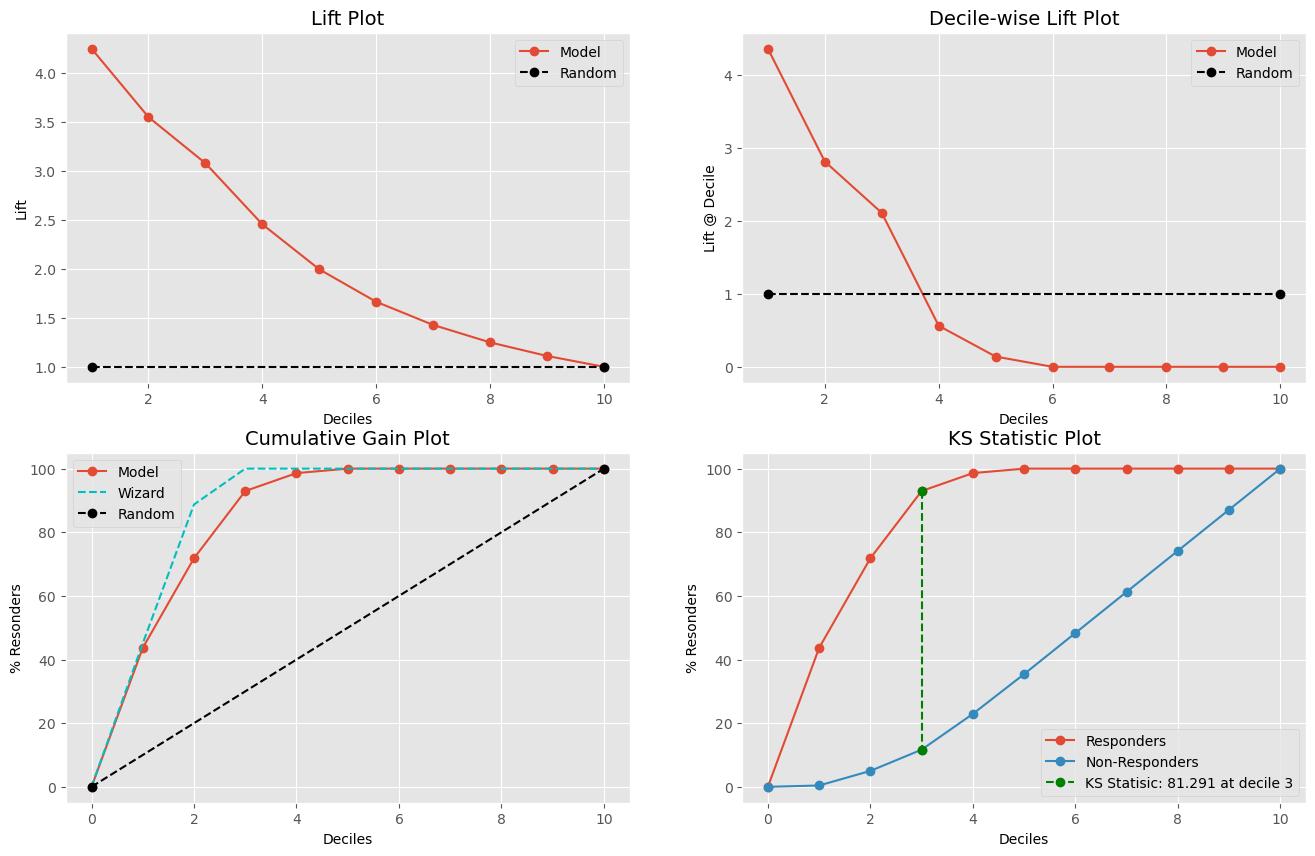

In [48]:
# Reporte de Deciles y Gráficos
kds.metrics.report(y_test, y_probs, plot_style='ggplot')

Comparando los resultados, el mejor modelo es XGBoost, por eso será el que se lleve al proceso de Scoring

<font color='red'/>

## **Scoring del Modelo XGB entrenado en Python utilizando BYOM en la BD**

In [57]:
con.execute("CREATE SET TABLE DW_LANDING.pmml_models (model_id VARCHAR(40) \
            CHARACTER SET LATIN NOT CASESPECIFIC, model BLOB(2097088000)) \
            PRIMARY INDEX ( model_id );")

In [58]:
model_bytes = open("ModelLGBPy.pmml", "rb").read()
con.execute("insert into DW_LANDING.pmml_models  (model_id, model) values(?,?)", 'lgb_model', model_bytes)

In [59]:
pd.read_sql("select * from DW_LANDING.pmml_models", con)

,model_id,model
0,lgb_model,"b'<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<P..."


In [52]:
copy_to_sql(inputScore.result, schema_name="DW_LANDING", table_name="matriz_score", if_exists="replace")

In [54]:
pd.read_sql("select top 10 * from DW_LANDING.matriz_score", con)

,LAB_0002,VAR_0002_1,VAR_0002_2,VAR_0004,VAR_0006,VAR_0007,VAR_0008,VAR_0011,VAR_0012,VAR_0013,VAR_0015,VAR_0016,VAR_0018,VAR_0019,VAR_0020
0,ID_11423626,0,1,0,0.865941,0.341060,0.792079,0.670345,0.204686,0.259260,0.492030,0.493858,0.454545,0.235041,0.720026
1,ID_11423626,0,1,0,0.125275,0.620008,0.356436,0.623596,0.023086,0.830608,0.407453,0.262161,0.272727,0.034150,0.609900
2,ID_1484045,0,0,0,0.155121,0.252659,0.980198,0.773475,0.227251,0.845441,0.041436,0.905335,0.636364,0.016173,0.893053
3,ID_1484045,0,0,0,0.659613,0.601345,0.445545,0.977929,0.698870,0.580827,0.102227,0.904682,0.727273,0.403910,0.469102
4,ID_1831897,0,1,0,0.219305,0.704796,0.178218,0.260433,0.123609,0.667843,0.676927,0.981239,0.727273,0.519154,0.421956
5,ID_1831897,0,1,0,0.781992,0.485551,0.396040,0.113563,0.726006,0.551328,0.504204,0.630198,0.363636,0.853587,0.958187
6,ID_11843244,1,0,0,0.172190,0.401967,0.811881,0.817817,0.523356,0.897577,0.692674,0.028265,0.272727,0.684208,0.219765
7,ID_11423626,1,0,0,0.487822,0.956352,0.861386,0.969904,0.421970,0.354886,0.442033,0.662857,1.000000,0.799253,0.346742
8,ID_11946491,0,0,0,0.567778,0.533915,0.415842,0.794141,0.126728,0.645783,0.386845,0.012532,0.727273,0.482137,0.018175
9,ID_13959793,0,0,0,0.179776,0.247140,0.247525,0.213283,0.537988,0.522936,0.959520,0.702183,0.909091,0.582057,0.514114


In [61]:
con.execute("CREATE TABLE DW_LANDING.ScoreResult AS ( \
SELECT * FROM mldb.PMMLPredict( \
    ON (SELECT * FROM DW_LANDING.matriz_score) \
    ON (select * from DW_LANDING.pmml_models where model_id='lgb_model') DIMENSION \
    USING \
        Accumulate('LAB_0002') \
        ModelOutputFields ('probability_0', 'probability_1') \
) AS dt \
) WITH DATA;")

In [62]:
con.execute('UPDATE DW_LANDING.ScoreResult SET prediction=0 WHERE "probability_0" GT "probability_1";')

In [63]:
con.execute('UPDATE DW_LANDING.ScoreResult SET prediction=1 WHERE "probability_1" GT "probability_0";')

In [64]:
result_df = DataFrame.from_query("select top 10 * FROM DW_LANDING.ScoreResult;")
result_df.head()

LAB_0002,prediction,probability_0,probability_1
ID_12698928,0,0.9623589955316812,0.037641004468318764
ID_13031125,0,0.9999700632230863,2.9936776913664525e-05
ID_13031125,0,0.9936676301299936,0.0063323698700064
ID_13119292,0,0.9999777784398587,2.222156014129487e-05
ID_13305747,0,0.9784057286981802,0.021594271301819772
ID_13305747,0,0.9958715347565089,0.00412846524349113
ID_13298241,0,0.9995914312449226,0.00040856875507741346
ID_12731831,0,0.9985195343473654,0.0014804656526346417
ID_12387220,1,0.008410541122211401,0.9915894588777886
ID_12251907,0,0.9984899397097066,0.0015100602902934756


## **Finalizando la Demo**

In [65]:
con.execute("DROP TABLE DW_LANDING.TrainModel;")

In [66]:
con.execute("DROP TABLE DW_LANDING.TestModel;")

In [67]:
con.execute("DROP TABLE DW_LANDING.pmml_models;")

In [68]:
con.execute("DROP TABLE DW_LANDING.matriz_score;")

In [69]:
con.execute("DROP TABLE DW_LANDING.ScoreResult;")

In [70]:
## Finalizando el Notebook y Limpiando el ambiente 
remove_context()

True

![Slide](images/Diapositiva13.PNG)

![Slide](images/Diapositiva14.PNG)

Copyright 2023. Elaborado por Luis Cajachahua bajo licencia MIT